CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **four** hidden layers with tapering width [256, 128, 64, 32] neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers and implement L2 weight decay with **weight_decay = 0.01**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

Define the model class.

In [2]:
class MLP(nn.Module):
# TODO: Enter your code here

    def __init__(self, input_dim=57, hidden_sizes=[256, 128, 64, 32]):  
        super(MLP, self).__init__()
        
        # Build layers dynamically based on hidden_sizes
        layers = []
        current_input_size = input_dim
        
        # Add hidden layers with tapering pattern
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            current_input_size = hidden_size
        
        # Add output layer
        layers.append(nn.Linear(current_input_size, 1))
        layers.append(nn.Sigmoid())
        
        self.mlp_stack = nn.Sequential(*layers)

    def forward(self, x, return_logits=False):
        if return_logits:
            # Remove the last sigmoid layer to get logits
            layers = list(self.mlp_stack.children())[:-1]  # All layers except sigmoid
            x = nn.Sequential(*layers)(x)
            logits = x
            prob = torch.sigmoid(logits)
            return (logits, prob)
        else:
            return self.mlp_stack(x)

In [3]:
df = pd.read_csv('audio_gtzan.csv')
df.head()

,filename,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,blues.00000.0.wav,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
1,blues.00000.1.wav,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
2,blues.00000.2.wav,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
3,blues.00000.3.wav,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,blues.00000.4.wav,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694


> Divide the dataset into a 75:25 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [4]:
from common_utils import split_dataset, preprocess_dataset
# TODO: Enter your code here

# Create labels from 'filename'
df['label'] = df['filename'].str.split('.').str[0]
print(df['label'].value_counts())

# Define parameters
columns_to_drop = ['filename', 'label']
test_size = 0.25
random_state = 42

# Split dataset and preprocess
df_train, y_train, df_test, y_test = split_dataset(df, columns_to_drop, test_size, random_state)
X_train, X_test = preprocess_dataset(df_train, df_test)

label
blues    1000
metal    1000
Name: count, dtype: int64


> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **'Adam'** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **5**.

1. Define a Pytorch Dataset and Dataloaders.  

In [5]:
# TODO: Enter your code here

from common_utils import AudioDataset

# Define batch size
batch_size = 128

# Create PyTorch Dataset 
train_dataset = AudioDataset(X_train, torch.tensor(y_train, dtype=torch.float32))
test_dataset  = AudioDataset(X_test, torch.tensor(y_test, dtype=torch.float32))

# Create DataLoaders for mini-batch training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

2. Next, define the model, optimizer and loss function.

In [6]:
# TODO: Enter your code here

model = MLP(input_dim=X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [7]:
from common_utils import EarlyStopper

# TODO: Enter your code here

epochs = 100
early_stopper = EarlyStopper(patience=5)

# Lists to store loss and accuracy history
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(epochs):

    model.train()
    total_loss = 0.0
    correct_train = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        # Convert predicted probabilities to binary class labels (0 or 1)
        preds = (outputs >= 0.5).float()   
        correct_train += (preds == labels).sum().item()
    
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / len(train_loader.dataset)

    # Validation
    model.eval()
    total_loss = 0.0
    correct_test = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            
            preds = (outputs >= 0.5).float()
            correct_test += (preds == labels).sum().item()
        
    average_validation_loss = total_loss / len(test_loader)
    test_accuracy = correct_test / len(test_loader.dataset)
    
    # Record metrics
    train_losses.append(average_train_loss)
    test_losses.append(average_validation_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    # Display metrics
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {average_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {average_validation_loss:.4f}, Val Acc: {test_accuracy:.4f}")
    
    # Stop training if validation loss does not improve after 5 epochs
    if early_stopper.early_stop(average_validation_loss):
        print("Early stopping triggered.")
        break

Epoch 1 | Train Loss: 0.6784, Train Acc: 0.5740 | Val Loss: 0.6518, Val Acc: 0.7780
Epoch 2 | Train Loss: 0.5932, Train Acc: 0.8107 | Val Loss: 0.4758, Val Acc: 0.8500
Epoch 3 | Train Loss: 0.3824, Train Acc: 0.8720 | Val Loss: 0.2616, Val Acc: 0.9000
Epoch 4 | Train Loss: 0.2025, Train Acc: 0.9213 | Val Loss: 0.1998, Val Acc: 0.9200
Epoch 5 | Train Loss: 0.1509, Train Acc: 0.9487 | Val Loss: 0.1640, Val Acc: 0.9340
Epoch 6 | Train Loss: 0.1141, Train Acc: 0.9680 | Val Loss: 0.1315, Val Acc: 0.9500
Epoch 7 | Train Loss: 0.0976, Train Acc: 0.9707 | Val Loss: 0.1180, Val Acc: 0.9500
Epoch 8 | Train Loss: 0.0799, Train Acc: 0.9760 | Val Loss: 0.1045, Val Acc: 0.9600
Epoch 9 | Train Loss: 0.0585, Train Acc: 0.9887 | Val Loss: 0.0981, Val Acc: 0.9620
Epoch 10 | Train Loss: 0.0579, Train Acc: 0.9853 | Val Loss: 0.0917, Val Acc: 0.9640
Epoch 11 | Train Loss: 0.0508, Train Acc: 0.9873 | Val Loss: 0.0844, Val Acc: 0.9700
Epoch 12 | Train Loss: 0.0435, Train Acc: 0.9893 | Val Loss: 0.0785, Val A

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

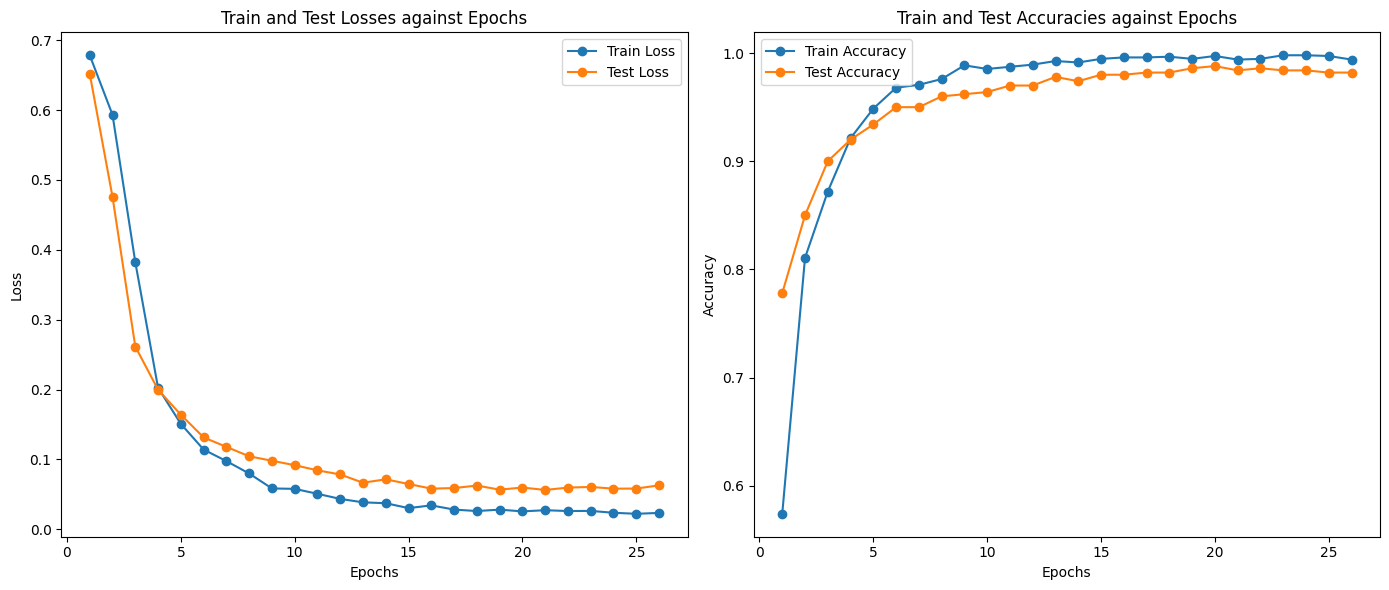

In [8]:
# TODO: Enter your code here

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses against Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracies against Epochs')
plt.legend()

plt.tight_layout()
plt.show()


\# TODO: 

#### The loss for training and test data decreases rapidly during the first few epochs, indicating that the model is able to quickly learned to minimise prediction errors. After around 10 epochs, the loss values begin to converge, suggesting that the model achieved a stable optimisation. 

#### Similarly, the accuracy for training and test data increases sharply and plateau close to 100%, demonstrating excellent classification performance on both datasets. The close gap between the train and test curves further suggest a strong generalisation as the model is able to perform consistently on unseen data.

#### Overall, the results show that the model is well-trained and stable. It is also not underfitting or overfitting, with optimal performance likely achieved between epochs 15 and 20.

Part A, Q2 (10 marks)
---

In this question, we will determine the optimal learning rate for the Adam optimizer. Find the optimal learning rate by training the neural network and evaluating the performances for different learning rates. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [9]:
# TODO: Enter your code here

from common_utils import preprocess_dataset, AudioDataset, MLP

>Plot mean cross-validation accuracies and mean cross-validation AUC scores on the final epoch for different learning rates as scatter plots. Limit search space to learning rates {0.0001, 0.0005, 0.001, 0.005, 0.01}. Keep batch_size fixed at 128. Create a table of time taken to train the network on the last epoch against different learning rates. Generate a confusion matrix for the optimal learning rate configuration. Finally, select the optimal learning rate and state a reason for your selection.

1. Define different folds for different learning rates to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[learning_rate] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[learning_rate] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[learning_rate] and y_val_dict[learning_rate] is a list of labels for the different folds.

In [10]:
# TODO: Enter your code here

# Define learning rates
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Convert to numpy
X_train_all = df_train.values
y_train_all = y_train.reshape(-1, 1)

# Dictionaries to store scaled folds
X_train_scaled_dict = {}
X_val_scaled_dict = {}
y_train_dict = {}
y_val_dict = {}

for lr in learning_rates:
    X_train_scaled_dict[lr] = []
    X_val_scaled_dict[lr] = []
    y_train_dict[lr] = []
    y_val_dict[lr] = []
    
    for train_idx, val_idx in kfold.split(X_train_all):
        X_tr, X_val = X_train_all[train_idx], X_train_all[val_idx]
        y_tr, y_val = y_train_all[train_idx], y_train_all[val_idx]

        # scale each fold separately
        X_tr_scaled, X_val_scaled = preprocess_dataset(
            pd.DataFrame(X_tr), pd.DataFrame(X_val)
        )

        X_train_scaled_dict[lr].append(X_tr_scaled)
        X_val_scaled_dict[lr].append(X_val_scaled)
        y_train_dict[lr].append(y_tr)
        y_val_dict[lr].append(y_val)



2. Perform hyperparameter tuning for the different learning rates with 5-fold cross validation.

In [11]:
# TODO: Enter your code here

from sklearn.metrics import accuracy_score, roc_auc_score

batch_size = 128
epochs = 50
results = []

for lr in learning_rates:
    fold_accs = []
    fold_aucs = []
    print(f"\nLearning rate: {lr}")
    
     # 5-Fold Cross-Validation
    for fold in range(5):
        X_tr_scaled = X_train_scaled_dict[lr][fold]
        X_val_scaled = X_val_scaled_dict[lr][fold]
        y_tr = y_train_dict[lr][fold]
        y_val = y_val_dict[lr][fold]

        # Prepare datasets and loaders
        train_ds = AudioDataset(X_tr_scaled, torch.tensor(y_tr.flatten(), dtype=torch.float32))
        val_ds = AudioDataset(X_val_scaled, torch.tensor(y_val.flatten(), dtype=torch.float32))

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

        # Initialize model, loss function, and optimizer
        model = MLP(input_dim=X_tr_scaled.shape[1])
        loss_fn = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)

        early_stopper = EarlyStopper(patience=5)

        # Training loop
        start_time = time.time()
        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                preds = model(xb)
                loss = loss_fn(preds, yb)
                loss.backward()
                optimizer.step()
            
            # Validation step for early stopping
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    preds = model(xb)
                    loss = loss_fn(preds, yb)
                    val_loss += loss.item()

            # Early stopping condition
            if early_stopper.early_stop(val_loss):
                print(f"Early stopping at epoch {epoch+1} for fold {fold+1}.")
                break

        end_time = time.time()

        # Evaluate model performance on validation set
        model.eval()
        all_preds = []
        all_true = []
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                all_preds.extend(preds.numpy().flatten())
                all_true.extend(yb.numpy().flatten())

        all_preds, all_true = np.array(all_preds), np.array(all_true)
        acc = accuracy_score(all_true, (all_preds >= 0.5).astype(int))
        auc = roc_auc_score(all_true, all_preds)
        fold_accs.append(acc)
        fold_aucs.append(auc)

        print(f"Fold {fold+1}: Acc={acc:.3f}, AUC={auc:.3f}")

    # Store mean metrics and training time for the last epoch
    results.append({
        "lr": lr,
        "mean_acc": np.mean(fold_accs),
        "mean_auc": np.mean(fold_aucs),
        "time_last_epoch(s)": end_time - start_time
    })





Learning rate: 0.0001
Fold 1: Acc=0.963, AUC=0.990
Fold 2: Acc=0.953, AUC=0.987
Fold 3: Acc=0.973, AUC=0.992
Fold 4: Acc=0.970, AUC=0.993
Fold 5: Acc=0.973, AUC=0.996

Learning rate: 0.0005
Fold 1: Acc=0.983, AUC=0.997
Early stopping at epoch 40 for fold 2.
Fold 2: Acc=0.977, AUC=0.997
Early stopping at epoch 33 for fold 3.
Fold 3: Acc=0.983, AUC=0.998
Early stopping at epoch 33 for fold 4.
Fold 4: Acc=0.983, AUC=0.997
Early stopping at epoch 35 for fold 5.
Fold 5: Acc=0.977, AUC=0.998

Learning rate: 0.001
Early stopping at epoch 31 for fold 1.
Fold 1: Acc=0.980, AUC=0.997
Early stopping at epoch 35 for fold 2.
Fold 2: Acc=0.980, AUC=0.996
Early stopping at epoch 31 for fold 3.
Fold 3: Acc=0.987, AUC=1.000
Early stopping at epoch 30 for fold 4.
Fold 4: Acc=0.990, AUC=0.998
Early stopping at epoch 17 for fold 5.
Fold 5: Acc=0.973, AUC=0.997

Learning rate: 0.005
Early stopping at epoch 16 for fold 1.
Fold 1: Acc=0.963, AUC=0.992
Early stopping at epoch 16 for fold 2.
Fold 2: Acc=0.970

3. Plot scatterplot of mean cross validation accuracies and AUC scores on the final epoch for the different learning rates. Limit search space to learning rates {0.0001, 0.0005, 0.001, 0.005, 0.01}.


Summary


,lr,mean_acc,mean_auc,time_last_epoch(s)
0,0.0001,0.966667,0.991706,2.128616
1,0.0005,0.980667,0.997387,1.764212
2,0.0010,0.982000,0.997806,0.804414
3,0.0050,0.969333,0.994890,1.068085
4,0.0100,0.962000,0.995172,0.355297


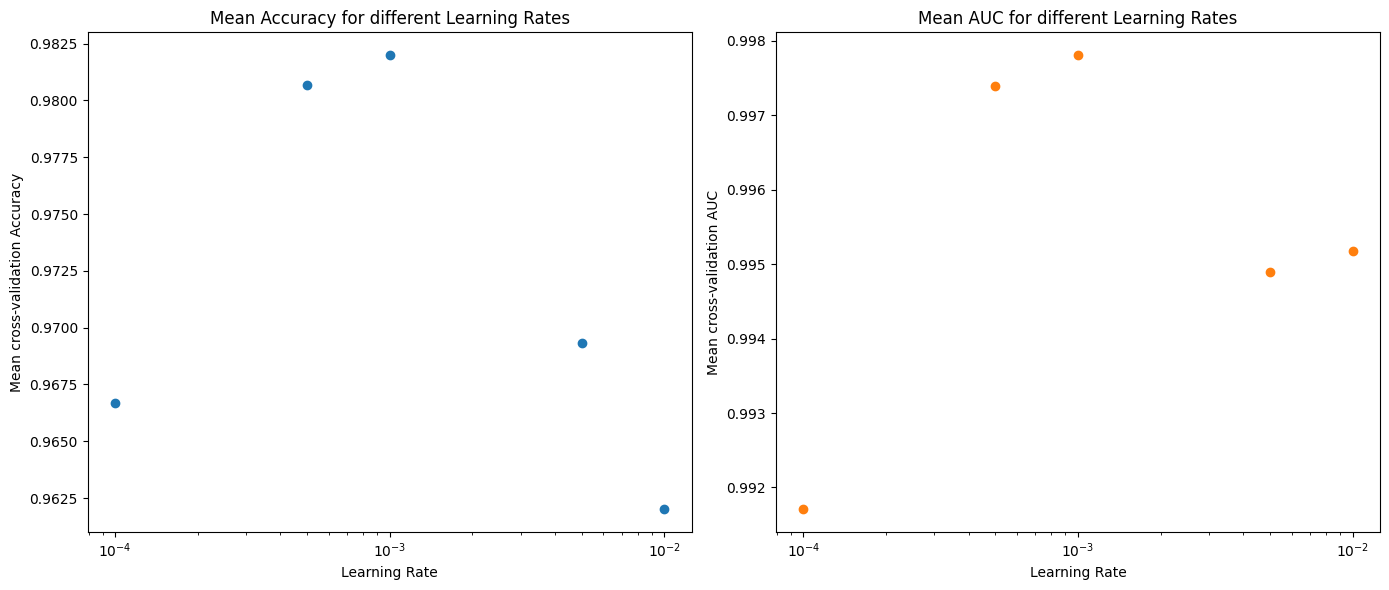

In [12]:
# TODO: Enter your code here

results_df = pd.DataFrame(results)
print("\nSummary")
display(results_df)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(results_df['lr'], results_df['mean_acc'], color='tab:blue')
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Mean cross-validation Accuracy")
plt.title("Mean Accuracy for different Learning Rates")

plt.subplot(1,2,2)
plt.scatter(results_df['lr'], results_df['mean_auc'], color='tab:orange')
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Mean cross-validation AUC")
plt.title("Mean AUC for different Learning Rates")

plt.tight_layout()
plt.show()


4. Create a table of time taken to train the network on the last epoch against different learning rates. Generate a confusion matrix for the optimal learning rate configuration.


Time taken to train against different learning rates


,lr,time_last_epoch(s)
0,0.0001,2.128616
1,0.0005,1.764212
2,0.0010,0.804414
3,0.0050,1.068085
4,0.0100,0.355297



Selected optimal learning rate: 0.001
Early stopping at epoch 30.


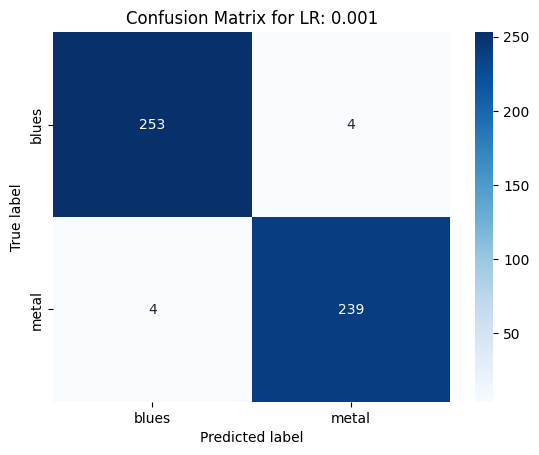

In [13]:
# TODO: Enter your code here

from sklearn.metrics import confusion_matrix
import seaborn as sns

print("\nTime taken to train against different learning rates")
display(results_df[['lr', 'time_last_epoch(s)']])

# Choose the best learning rate
best_lr = results_df.loc[results_df['mean_auc'].idxmax(), 'lr']
print(f"\nSelected optimal learning rate: {best_lr}")

# Retrain model using best learning rate
X_train_scaled, X_test_scaled = preprocess_dataset(df_train, df_test)
train_ds = AudioDataset(X_train_scaled, torch.tensor(y_train.flatten(), dtype=torch.float32))
test_ds  = AudioDataset(X_test_scaled, torch.tensor(y_test.flatten(), dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

model = MLP(input_dim=X_train_scaled.shape[1])
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=0.01)
early_stopper = EarlyStopper(patience=5)

# Training loop 
start_time = time.time()
for epoch in range(50):  
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
    
    # Early stopping condition
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item()

    # Check early stopping
    if early_stopper.early_stop(val_loss):
        print(f"Early stopping at epoch {epoch+1}.")
        break

end_time = time.time()

# Generate confusion matrix
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        all_preds.extend(preds.numpy().flatten())
        all_true.extend(yb.numpy().flatten())

# Convert predictions to labels based on threshold (0.5)
pred_labels = (np.array(all_preds) >= 0.5).astype(int)

# Compute and plot confusion matrix
cm = confusion_matrix(all_true, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['blues', 'metal'], yticklabels=['blues', 'metal'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix for LR: {best_lr}')
plt.show()

5. Select the optimal learning rate and state a reason for your selection.

\# TODO:
#### The optimal learning rate selected is 0.001, as it achieved the highest mean cross-validation Accuracy and AUC. At 0.001 learning rate, the model demonstrates excellent performance (as shown in the Confusion Matrix with very few false positives/negatives) and decent training time as well.

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 5-layer network (4 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [14]:
# TODO: Enter your code here

from common_utils import AudioDataset, MLP

> Plot the mean cross-validation accuracies on the final epoch for different numbers of first hidden-layer neurons using a scatter plot. Maintain the tapering pattern (e.g., if first layer is 256, use [256, 128, 64, 32]). Limit the search space of the first layer neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Add ROC curve plotting for the final selected architecture.

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [15]:
# TODO: Enter your code here

batch_size = 128
num_epochs = 50
neuron_configs = [64, 128, 256]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mean_acc_dict = {}
mean_auc_dict = {}
training_time_dict = {}

for n_neurons in neuron_configs:
    print(f"\nHidden layers architecture: [{n_neurons}, 128, 64, 32]")
    fold_accs, fold_aucs, fold_times = [], [], []
    all_preds, all_true = [], []  # For ROC curve plotting

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Scale within each fold
        scaler = preprocessing.StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)

        # Create Datasets
        train_ds = AudioDataset(X_tr_scaled, torch.tensor(y_tr, dtype=torch.float32))
        val_ds = AudioDataset(X_val_scaled, torch.tensor(y_val, dtype=torch.float32))
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        # Initialize model, optimizer, and loss
        model = MLP(input_dim=X_train.shape[1], hidden_sizes=[n_neurons, 128, 64, 32])
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
        loss_fn = torch.nn.BCELoss()

        early_stopper = EarlyStopper(patience=5)

        start_time = time.time()
        
        # Training loop 
        for epoch in range(num_epochs):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()

            # Early stopping condition
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    out = model(xb)
                    loss = loss_fn(out, yb)
                    val_loss += loss.item()

            # Check early stopping
            if early_stopper.early_stop(val_loss):
                print(f"  Early stopping at epoch {epoch+1} for fold {fold+1}.")
                break

        elapsed = time.time() - start_time

        # Evaluate on validation fold
        model.eval()
        preds, probs, labels = [], [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                preds += (out > 0.5).float().numpy().flatten().tolist()
                probs += out.cpu().numpy().flatten().tolist()
                labels += yb.numpy().flatten().tolist()

        acc = accuracy_score(labels, preds)
        auc_score = roc_auc_score(labels, probs)
        fold_accs.append(acc)
        fold_aucs.append(auc_score)
        fold_times.append(elapsed)

        all_preds.extend(probs)  # For ROC curve
        all_true.extend(labels)

        print(f"  Fold {fold+1}: Acc={acc:.4f}, AUC={auc_score:.4f}")

    mean_acc_dict[n_neurons] = np.mean(fold_accs)
    mean_auc_dict[n_neurons] = np.mean(fold_aucs)
    training_time_dict[n_neurons] = np.mean(fold_times)



Hidden layers architecture: [64, 128, 64, 32]
  Early stopping at epoch 40 for fold 1.
  Fold 1: Acc=0.9800, AUC=0.9977
  Early stopping at epoch 30 for fold 2.
  Fold 2: Acc=0.9767, AUC=0.9945
  Fold 3: Acc=0.9900, AUC=0.9995
  Early stopping at epoch 34 for fold 4.
  Fold 4: Acc=0.9833, AUC=0.9978
  Early stopping at epoch 23 for fold 5.
  Fold 5: Acc=0.9833, AUC=0.9975

Hidden layers architecture: [128, 128, 64, 32]
  Early stopping at epoch 39 for fold 1.
  Fold 1: Acc=0.9833, AUC=0.9984
  Early stopping at epoch 24 for fold 2.
  Fold 2: Acc=0.9667, AUC=0.9948
  Early stopping at epoch 36 for fold 3.
  Fold 3: Acc=0.9900, AUC=0.9993
  Early stopping at epoch 36 for fold 4.
  Fold 4: Acc=0.9867, AUC=0.9985
  Early stopping at epoch 21 for fold 5.
  Fold 5: Acc=0.9833, AUC=0.9973

Hidden layers architecture: [256, 128, 64, 32]
  Early stopping at epoch 34 for fold 1.
  Fold 1: Acc=0.9833, AUC=0.9979
  Early stopping at epoch 36 for fold 2.
  Fold 2: Acc=0.9733, AUC=0.9963
  Early st

2. Plot the mean cross-validation accuracies on the final epoch for different numbers of first hidden-layer neurons using a scatter plot. Limit the search space of the first layer neurons to {64, 128, 256}.

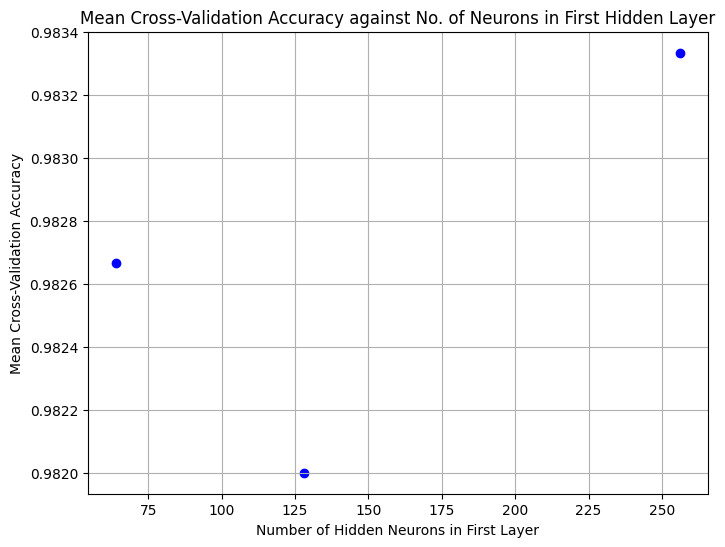

In [16]:
# Plot the mean cross-validation accuracies
plt.figure(figsize=(8, 6))
plt.scatter(neuron_configs, list(mean_acc_dict.values()), color='blue')
plt.xlabel('Number of Hidden Neurons in First Layer')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean Cross-Validation Accuracy against No. of Neurons in First Hidden Layer')
plt.grid(True)
plt.show()


> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [17]:
# TODO: Enter your code here

best_neurons = max(mean_acc_dict, key=mean_acc_dict.get)
print(f"Optimal first hidden layer neurons: {best_neurons}")


Optimal first hidden layer neurons: 256


\# TODO:
#### The optimal hidden layers architecture was found to be [256, 128, 64, 32], where the first hidden layer contains 256 neurons. This architecture achieved the highest mean cross-validation accuracy compared to 64 and 128 neurons (in the first hidden layer), suggesting that it is able to capture more complex patterns in the audio features without overfitting.

In [18]:
# Retrain the model using the best number of neurons
model = MLP(input_dim=X_train.shape[1], hidden_sizes=[best_neurons, 128, 64, 32])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
loss_fn = torch.nn.BCELoss()

train_accs, test_accs = [], []

early_stopper = EarlyStopper(patience=5)

for epoch in range(num_epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()

    # Evaluate on train set
    model.eval()
    train_preds, train_labels = [], []
    with torch.no_grad():
        for xb, yb in train_loader:
            out = model(xb)
            train_preds += (out > 0.5).float().numpy().flatten().tolist()
            train_labels += yb.numpy().flatten().tolist()

    train_acc = accuracy_score(train_labels, train_preds)
    train_accs.append(train_acc)

    # Evaluate on test set
    test_preds, test_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            out = model(xb)
            test_preds += (out > 0.5).float().numpy().flatten().tolist()
            test_labels += yb.numpy().flatten().tolist()

    test_acc = accuracy_score(test_labels, test_preds)
    test_accs.append(test_acc)

    # Calculate validation loss for early stopping
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:  
            out = model(xb)
            loss = loss_fn(out, yb)
            val_loss += loss.item()

    # Early stopping condition
    if early_stopper.early_stop(val_loss):
        print(f"Early stopping at epoch {epoch+1}.")
        break

# Save the model's state_dict for Part A, Q4
torch.save(model.state_dict(), 'best_model.pth')  

Early stopping at epoch 50.


> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot. Add ROC curve plotting for the final selected architecture.
Note: use this optimal number of neurons for the rest of the experiments.

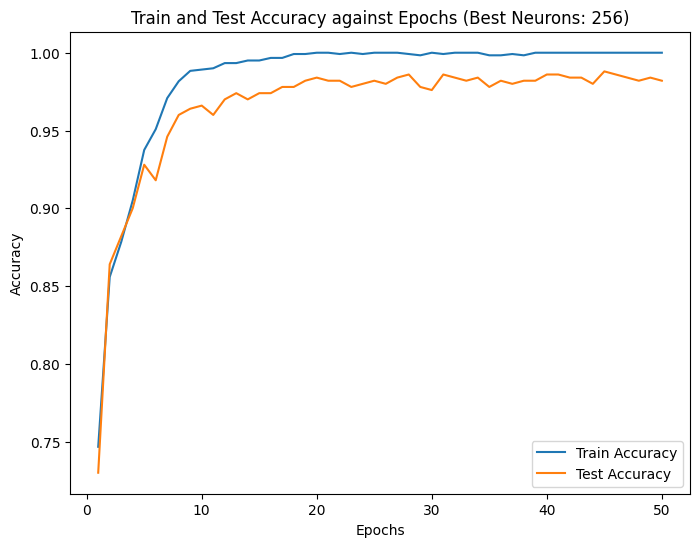

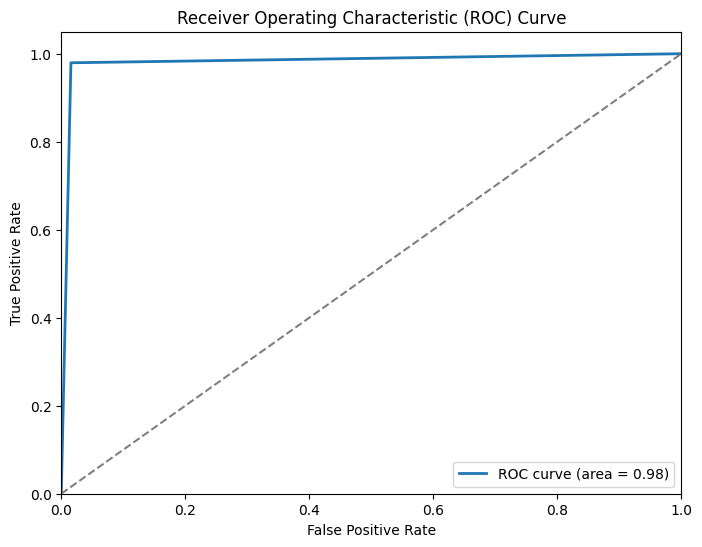

In [19]:
# TODO: Enter your code here

from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(test_accs) + 1), test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Train and Test Accuracy against Epochs (Best Neurons: {best_neurons})')
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Please use the 'audio_test.wav' as a test sample. Preprocess the data using the function 'extract_features' in common_utils.py. 
Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal learning rate and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations. 
Identify the top 5 most influential features (both positive and negative) and explain why these features make sense for music genre classification (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

Identify the top 5 most influential features (both positive and negative) and explain why these features make sense for music genre classification.


To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [20]:
# TODO: Enter your code here

from common_utils import extract_features, preprocess_dataset, MLP

> Install and import shap

In [21]:
# TODO: Enter your code here

!pip install shap
import shap



[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\Jun Sheng\OneDrive\Desktop\SC4001 Programming Assignment 1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> Preprocess 'audio_test.wav' in the folder 'audio' using the function 'extract_features' in common_utils.py. Use a pandas dataframe to store the features, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [22]:
import IPython
IPython.display.Audio("./audio_test.wav")

In [23]:
# TODO: Enter your code here

audio_file_path = 'audio_test.wav'

# Extract features from the audio file
features = extract_features(audio_file_path)

df = pd.DataFrame(features)
size_row, size_column = df.shape

# Display the DataFrame shape
print(f"DataFrame shape: {size_row} rows, {size_column} columns")
df.head()

DataFrame shape: 1 rows, 58 columns


,filename,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,audio_test.wav,0.431877,0.080057,0.056604,0.000293,1191.619716,40957.603068,1726.917471,38831.324373,2794.225223,...,-3.746181,56.647854,-6.391425,37.167591,-2.303412,43.675926,-8.247708,30.502138,-13.78649,46.94154


> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal learning rate and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [24]:
# TODO: Enter your code here

test_data = df.drop(columns=['filename'], axis=1) 

df = pd.read_csv('audio_gtzan.csv')
train_data = df.drop(columns=['filename'], axis=1) 

train_data_scaled, test_data_scaled = preprocess_dataset(train_data, test_data)
print(test_data_scaled)

# Save the features to a .npy file
np.save('test_data.npy', test_data_scaled)  

print(f"Shape of test data: {test_data_scaled.shape}")


[[ 0.21480575 -0.08165583 -1.43353047 -0.80598697 -1.48440982 -0.90692168
  -1.07033835 -0.59679038 -1.2558019  -0.62968411 -1.42612105 -0.99546318
   0.50888238 -0.98914924  0.92441948 -1.00064027 -1.05692916 -1.55379306
  -0.26394758  1.55720581 -0.66212626  0.76626097 -0.77088168  0.16945777
  -0.5780125  -0.07225713 -0.55815598  0.34164007 -0.32788909  1.41612609
  -0.76677855 -0.53826601 -0.5051983   0.50452468 -0.619945   -0.42303013
  -0.85931906  0.83722603  0.03156346 -0.75307102  0.30341281 -1.31836505
  -0.76050964 -1.09434553 -0.51963146 -0.59268245 -0.63734147 -1.11344899
   0.44534033  0.35563458 -0.25949634 -0.65377481 -0.05363914 -0.76716673
  -0.50778555 -2.36909721  0.01566793]]
Shape of test data: (1, 57)


2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal learning rate and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [25]:
# TODO: Enter your code here

test_data_scaled = np.load('test_data.npy') 

# Convert test data to torch tensor
test_input = torch.tensor(test_data_scaled, dtype=torch.float32)

# Define the model architecture
model = MLP(input_dim=test_input.shape[1], hidden_sizes=[best_neurons, 128, 64, 32])

# Load pretrained weights from Part A, Q3
model.load_state_dict(torch.load('best_model.pth')) 
model.eval()

# Make prediction
with torch.no_grad():
    output = model(test_input)            
    prob = output.item()                 
    pred_label = 1 if prob >= 0.5 else 0  # Apply threshold of 0.5

label_name = "metal" if pred_label == 1 else "blues"
print(f"Predicted probability: {prob:.4f}")
print(f"Predicted label: {pred_label} ({label_name})")


Predicted probability: 0.0109
Predicted label: 0 (blues)


\# TODO: 

#### The SHAP force plot below illustrates how each features contributed to the model’s prediction for a single test sample. The Red portion indicates features that increase the model’s output (pushing the prediction towards the "metal" class). Whereas the Blue portion indicates features that decrease the model’s output (pushing the prediction towards the "blues” class). From the plot, we can clearly see that spectral_centroid_mean is the most influential features pushing the model's prediction towards the "blues" class.

> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 


Identify the top 5 most influential features (both positive and negative) and explain why these features make sense for music genre classification.


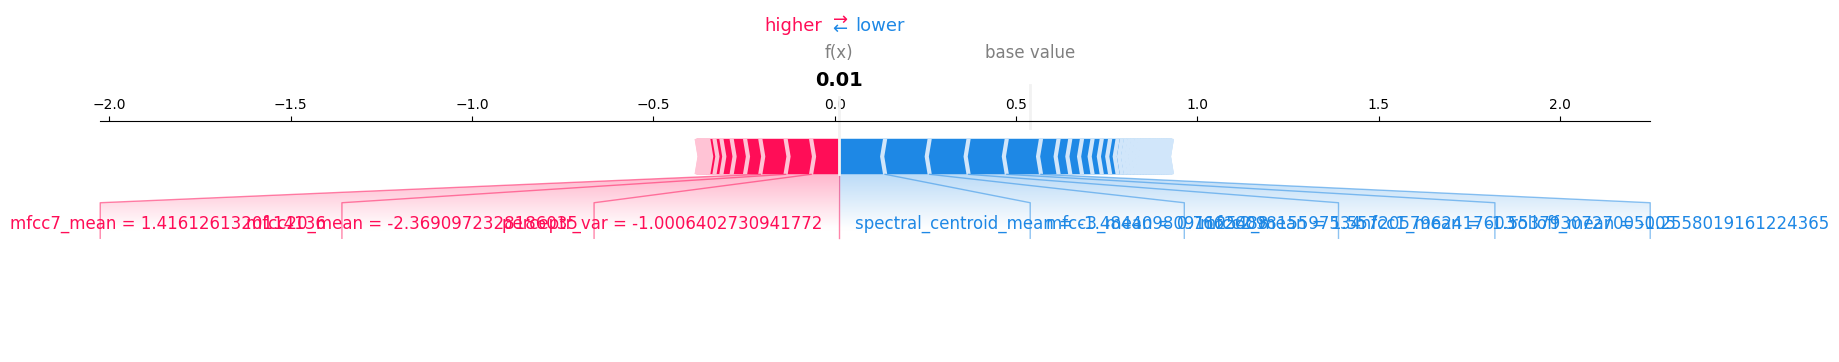


Top 5 Influential Features (with SHAP values):
spectral_centroid_mean: -0.1280 (negative influence)
mfcc3_mean: -0.1228 (negative influence)
mfcc2_mean: -0.1072 (negative influence)
mfcc1_mean: -0.1054 (negative influence)
rolloff_mean: -0.0943 (negative influence)


In [26]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# TODO: Enter your code here

# Randomly select 100 entries from training data as SHAP background
num_background = min(100, len(train_data_scaled))
random_indices = np.random.choice(len(train_data_scaled), num_background, replace=False)

background = torch.tensor(train_data_scaled[random_indices], dtype=torch.float32)

# Convert test data (single record) to tensor
test_sample = torch.tensor(test_data_scaled, dtype=torch.float32)

# Create SHAP explainer and compute SHAP values
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_sample)

shap.initjs()

audio_test_np = test_sample.detach().numpy()
shap_vals = shap_values[0] if isinstance(shap_values, list) else shap_values
shap_vals = np.squeeze(shap_vals)

feature_names = train_data.columns.tolist()

shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_vals,
    features=audio_test_np[0],
    feature_names=feature_names,
    matplotlib=True

)

# Identify and print top 5 influential features
abs_shap = np.abs(shap_vals)
sorted_idx = np.argsort(abs_shap)[::-1]
top_features = [(feature_names[i], shap_vals[i]) for i in sorted_idx[:5]]

print("\nTop 5 Influential Features (with SHAP values):")
for name, val in top_features:
    direction = "positive" if val > 0 else "negative"
    print(f"{name}: {val:.4f} ({direction} influence)")

\# TODO:

#### The top 5 most influential features identified by SHAP are spectral_centroid_mean, mfcc1_mean, mfcc2_mean, mfcc3_mean, and rolloff_mean. All these features have negative SHAP values, meaning they contribute to lowering the model’s predicted probability in this test instance. These features are closely linked to timbre and spectral balance, which are crucial to distinguishing musical genres. Specifically, they capture tonal brightness, frequency distribution, and sound texture. Energetic genres such as rock or pop usually has higher spectral centroid and rolloff values, reflecting strong high-frequency content, while calmer genres such as classical or jazz exhibit lower values, corresponding to smoother textures and reduced brightness. The negative SHAP values indicate that this test sample aligned more with the acoustic characteristics of a low-energy genre and hence classified as "blues".